# Experimentos com VKCM-K

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
import joblib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from src.vkcm import evaluate_varying_k, adjusted_rand_score, silhouette_score


In [13]:
import sys
from pathlib import Path

# Adiciona o caminho da pasta src ao sys.path
sys.path.append(str(Path("../src").resolve()))

{'uci_id': 96, 'name': 'SPECTF Heart', 'repository_url': 'https://archive.ics.uci.edu/dataset/96/spectf+heart', 'data_url': 'https://archive.ics.uci.edu/static/public/96/data.csv', 'abstract': 'Data on cardiac Single Proton Emission Computed Tomography (SPECT) images. Each patient classified into two categories: normal and abnormal.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 267, 'num_features': 44, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['diagnosis'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2001, 'last_updated': 'Tue Mar 19 2024', 'dataset_doi': '10.24432/C5N015', 'creators': ['Krzysztof Cios', 'Lukasz Kurgan', 'Lucy Goodenday'], 'intro_paper': None, 'additional_info': {'summary': "The dataset describes diagnosing of cardiac Single Proton Emission Computed Tomography (SPECT) images. Each of the patients is classified into t

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

In [14]:
# Carrega os dados balanceados e normalizados
X_train, y_train = joblib.load("../data/train_balanced.pkl")
X_val, y_val = joblib.load("../data/val_balanced.pkl")
X_test, y_test = joblib.load("../data/test_balanced.pkl")

# Junta tudo para clustering (sem separar)
X = np.concatenate([X_train, X_val, X_test], axis=0)
y = np.concatenate([y_train, y_val, y_test], axis=0)

print("Shape dos dados:", X.shape)
print("Distribuição das classes:", Counter(y))


Shape dos dados: (424, 44)
Distribuição das classes: Counter({np.int64(0): 212, np.int64(1): 212})


In [20]:
# Rodar experimento para K = 2, 3, 4, 5
best_k, best_result, all_results = evaluate_varying_k(X_train_scaled, y_true=y['diagnosis'], k_values=[2, 3, 4, 5], runs=500, gamma=1.0)

print(f"Melhor K encontrado: {best_k}")
print(f"Silhouette médio: {best_result['avg_silhouette']:.4f}")
print(f"ARI com classes reais: {best_result['ari']:.4f}")


Melhor K encontrado: 2
Silhouette médio: 0.1630
ARI com classes reais: -0.0610


**normalizado sem smote**
Melhor K encontrado: 2
Silhouette médio: 0.1489
ARI com classes reais: -0.0658


Melhor K encontrado: 2
Silhouette médio: 0.1635
ARI com classes reais: -0.0389


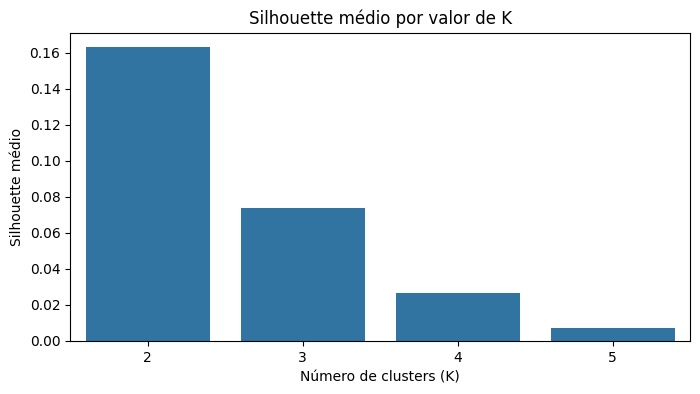

In [21]:
# Visualizar média de silhouette por K
avg_silhouettes = [all_results[k]['avg_silhouette'] for k in sorted(all_results.keys())]

plt.figure(figsize=(8, 4))
sns.barplot(x=sorted(all_results.keys()), y=avg_silhouettes)
plt.title('Silhouette médio por valor de K')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhouette médio')
plt.show()


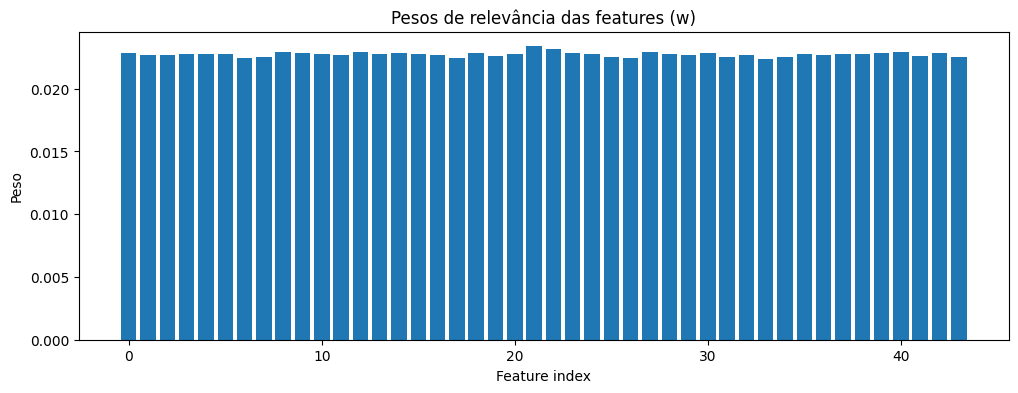

In [22]:
# Visualizar pesos de relevância da melhor execução
weights = best_result["relevance_weights"]
plt.figure(figsize=(12, 4))
plt.bar(range(len(weights)), weights)
plt.title("Pesos de relevância das features (w)")
plt.xlabel("Feature index")
plt.ylabel("Peso")
plt.show()


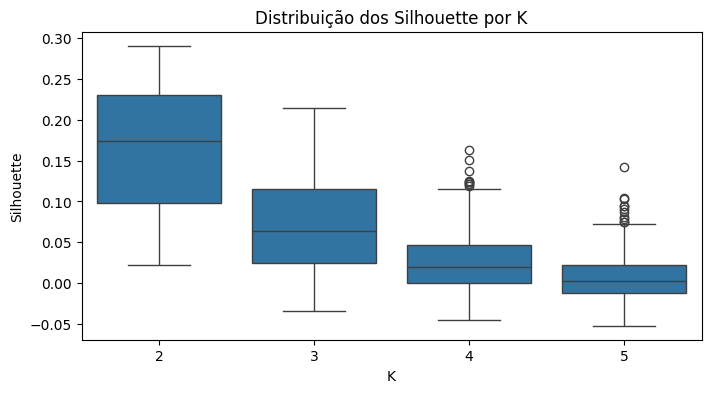

In [23]:
# Silhouette distribution between K
data = [(k, score) for k, res in all_results.items() for score in res['silhouette_scores']]
df_scores = pd.DataFrame(data, columns=["K", "Silhouette"])

plt.figure(figsize=(8, 4))
sns.boxplot(x="K", y="Silhouette", data=df_scores)
plt.title("Distribuição dos Silhouette por K")
plt.show()

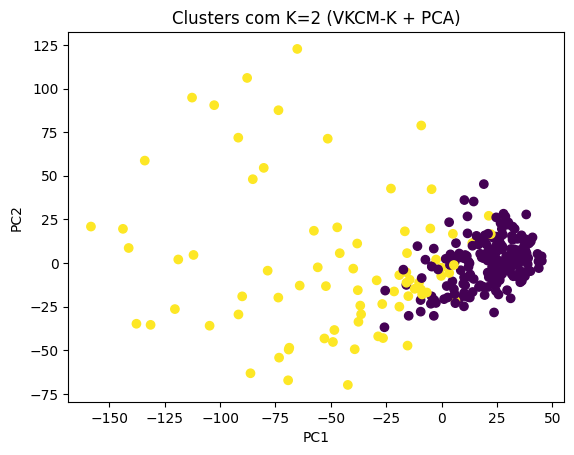

In [24]:
# plot dos pontos em 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_result["best_labels"], cmap='viridis')
plt.title(f"Clusters com K={best_k} (VKCM-K + PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [26]:
# comparação com Kmeans
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

print("KMeans ARI:", adjusted_rand_score(y['diagnosis'], kmeans_labels))
print("KMeans Silhouette:", silhouette_score(X_train_scaled, kmeans_labels))

KMeans ARI: -0.10672341054483249
KMeans Silhouette: 0.4143800387141985
